# Tarea Semanal 6: Estimación espectral. Ventanas en acción!
## Magdalena Noé
En esta tarea continuaremos con el capítulo 14 de Holton. DSP Principles and App.

Se trabajara sobre una señal con amplitud y frecuencia variable y se estimara su amplitud y frecuencia intrinseca con 4 tipos de ventanas:
- Rectangular (sin ventana)
- Flattop
- Blackmanharris
- Coseno
### Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft
from scipy.signal import windows
from matplotlib.ticker import FuncFormatter # Para modificar los ejes en gráficos de zero-padding
import pandas as pd # Para las tablas

import warnings 
warnings.filterwarnings("ignore") # Para ignorar una warning de matplotlib que le molesta como armo los historiogramas superpuestos
#warnings.filterwarnings("ignore", category='matplotlib.MatplotlibDeprecationWarning')

Parametros de la señal
Las variables aleateorias fr y na, correspondientes a la variacion de frecuencia y amplitud correspondientemente, se ven definidas por las siguientes distribuciones de probabilidad:

$$ fr∼U(−2,2);na∼N(0,σ^{2}) $$

In [2]:
fs = 1000       # Frecuencia de muestreo [Hz]
N = fs          # cantidad de muestras

a0 = 2                              #Amplitud señal
sigma = np.sqrt(1/10)               # SNR de 10dB
na = np.random.normal(0, sigma)     #Incertidumbre de amplitud

omega0 = np.pi/2                        #Frecuencia señal [Hz]
fr = np.random.uniform(-2, 2)           #Incertidumbre de frecuencia
omega1 = omega0 + fr*(2*np.pi)    #Frecuencia con incertidumbre


Generacion de señal

In [3]:
k = np.arange(N)                # Array de enteros de 0 a N-1
x = a0 * np.sin(omega1*k) + na  # Señal

Declaracion de las ventanas W

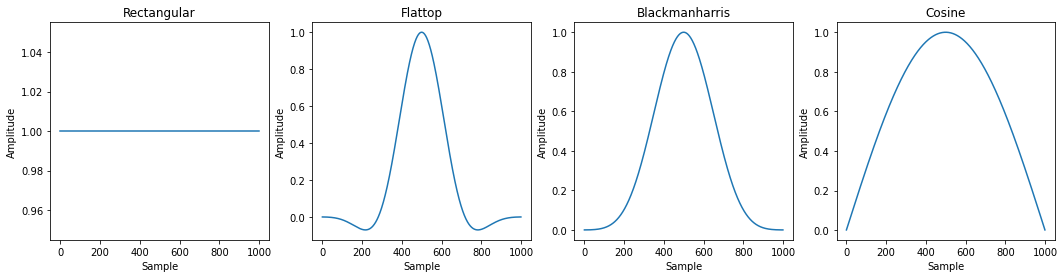

In [4]:
Wrectangular = windows.boxcar(N)                # Arr de 1 constantes, sin ventana
Wflattop = windows.flattop(N)                   # Ventana flattop (sombrero de bruja)
Wblackmanharris = windows.blackmanharris(N)     # Ventana blackmanharris (campana)
Wcosine = windows.cosine(N)                     # Ventana cosine (medio coseno, loma)
arr_W = [Wrectangular, Wflattop, Wblackmanharris, Wcosine]
arr_titulos_W = ["Rectangular", "flattop", "blackmanharris", "cosine"]

# GRAFICOS
plt.figure(figsize=(18, 4))
plt.subplot(1,4,1); plt.plot(Wrectangular); plt.title("Rectangular"); plt.ylabel("Amplitude"); plt.xlabel("Sample")
plt.subplot(1,4,2); plt.plot(Wflattop); plt.title("Flattop"); plt.ylabel("Amplitude"); plt.xlabel("Sample")
plt.subplot(1,4,3); plt.plot(Wblackmanharris); plt.title("Blackmanharris"); plt.ylabel("Amplitude"); plt.xlabel("Sample")
plt.subplot(1,4,4); plt.plot(Wcosine); plt.title("Cosine"); plt.ylabel("Amplitude"); plt.xlabel("Sample")
plt.show()

### Estimamos la amplitud $a_0$ y la frecuencia $ \omega_0 $. 
En ambos analisis se realiz un ventaneo de la señal $X$, por lo que recorreremos los 4 casos de ventanas declaradas anteriormente.

Para estimar la amplitud se realiza la fft de la señal ventaneada y lee el indice correspondiente a $\omega_0 = \pi/2$. A dicha estimacion la llamaremos $a_1$

$$ a^i1=|Xiw(Ω0)|=|F{x(n)⋅wi(n)}| $$

Para estimar la frecuencia se detecta el maximo valor de espectro (fft) y retorna la frecuencia en radianes. A dicha estimacion la llamaremos $Ω_1$

$$ Ω^i1=arg max{|Xiw(Ω)|} $$


In [5]:
def estimar_amplitud(Xw):
    omega0_ind = int(N // 4) # indice de omega0 = pi/2 -> frecuencia fo = fs/4 -> indice = N/4
    return Xw[omega0_ind] # Retorno el valor modulo en pi/2 (pico de señal seno)

def estimar_frecuencia(Xw):
    Xw = Xw[len(Xw)//2:]  # Solo tomo una mitad del array
    f_ind = np.argmax(Xw) # Retorna argumento con el maximo pico, que deberia corresponder a la frecuencia fundamental
    omega = 2 * np.pi * f_ind / N # Paso frecuencia a radianes/s
    return f_ind # Retorno frecuencia en hz

def estimar_amp_frec(x,w):
    xw = x * w
    fft_xw = np.array(np.abs(fft(xw)))
    amplitud = estimar_amplitud(fft_xw)
    frecuencia = estimar_frecuencia(fft_xw)
    return amplitud, frecuencia, fft_xw

## Experimentación

Una vez ya declarada la señal, las ventanas a aplicarle y las funciones para obtener una estimacion de amplitud y frecuencia, vamos a correr esta estimacion 200 veces (cant_realizaciones) con 1000 muestras por experimento (N).

La SNR se parametrizara para 3dB, con una alta presencia de ruido, y 10 dB, es decir, con un ruido mas atenuado.
Para los 8 casos (4 ventanas y 2 tipos de SNR) se analizara:
- Sesgo amplitud: diferencia promedio entre valor estimado y el real ($a_0 = 2$)
- Varianza amplitud: cuánto varían las estimaciones de amplitud entre realizaciones
- Sesgo frecuencia: diferencia promedio entre frecuencia estimada y real ($ω0 = π/2$)
- Varianza frecuencia: cuánto se dispersan las estimaciones de frecuencia

In [6]:
cant_realizaciones = 200
SNR_dB = [3, 10]
SNR_lin = [10**(SNR_dB[0]/10), 10**(SNR_dB[1]/10)]

In [7]:
P_signal = 1
P_noise = P_signal / SNR_lin[0]                         # SNR_lin[0] = 10**(3/10)
sigma = np.sqrt(P_noise)                                # sigma del ruido blanco gaussiano para 1/3dB
na_3dB = np.random.normal(0, sigma, size=(cant_realizaciones,N)) # 200 incertidumbres de amplitud para las 200 realizaciones

P_noise = P_signal / SNR_lin[1]                         # SNR_lin[1] = 10**(10/10)
sigma = np.sqrt(P_noise)                                # sigma del ruido blanco gaussiano para 1/10dB
na_10dB = np.random.normal(0, sigma, size=(cant_realizaciones,N))     # 200 incertidumbres de amplitud para las 200 realizaciones

fr = np.random.uniform(-2, 2, cant_realizaciones)       # 200 incertidumbres de frecuencia para las 200 realizaciones
omega1 = omega0 + fr*(2*np.pi/N)                          #Frecuencias con incertidumbre

omega1 = omega1.reshape((cant_realizaciones, 1))
k = k.reshape((1,N))

x_3dB = a0 * np.sin(omega1*k) + na_3dB                  # 200 señales con variacion con ruido de 3dB
x_10dB = x = a0 * np.sin(omega1*k) + na_10dB            # 200 señales con variacion con ruido de 10dB

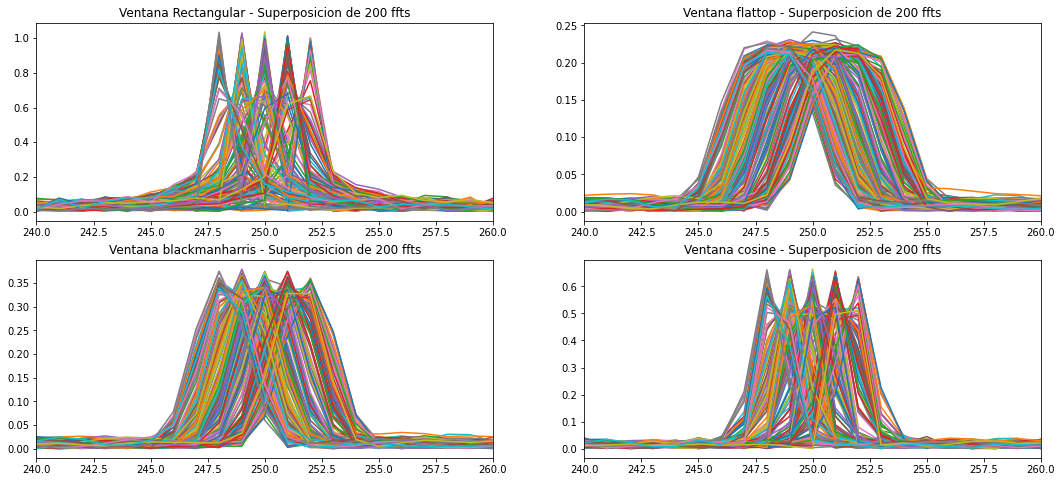

In [8]:
estimaciones_amp = np.zeros((len(arr_W), cant_realizaciones)) # Matriz de 4 filas 200 columnas
estimaciones_freq = np.zeros((len(arr_W), cant_realizaciones))

arr_ffts = np.zeros((len(arr_W), cant_realizaciones, N), dtype=complex)
for j in range(len(arr_W)):
    for i in range(cant_realizaciones):
        x_selec = x_3dB[i]  # señal i de doscientas
        w_selec = arr_W[j]  # Ventana 0 de cuatro, la rectangular (rectangular, flattop, blackmanharris, cosine)
        amplitud, frecuencia, fft_x = estimar_amp_frec(x_selec, w_selec)

        estimaciones_amp[j][i] = amplitud / N
        estimaciones_freq[j][i] = frecuencia
        arr_ffts[j,i, :] = fft_x / N
        
plt.figure(figsize=(18, 8))
for j in range(len(arr_W)):
    plt.subplot(2,2,j+1)
    plt.title(f"Ventana {arr_titulos_W[j]} - Superposicion de {cant_realizaciones} ffts")
    for i in np.arange(cant_realizaciones):
        plt.plot(np.real(arr_ffts[j][i]))
    plt.xlim(240,260)    
plt.show()

Calculo de sesgo y varianza

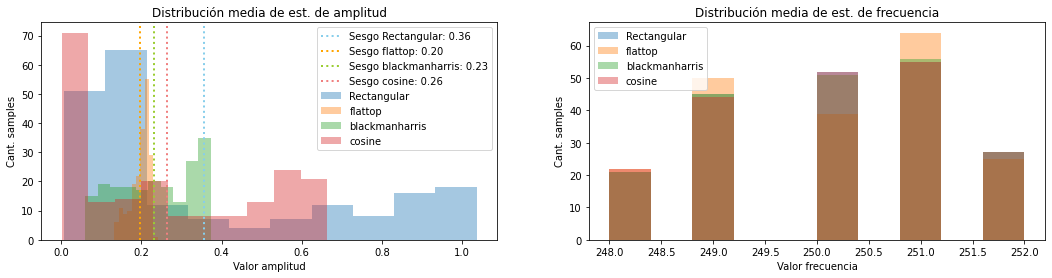

,Ventana,Sesgo,Varianza
0,Rectangular,0.356327,0.108420
1,flattop,0.195556,0.000545
2,blackmanharris,0.232357,0.008729
3,cosine,0.264392,0.051902


,Ventana,Sesgo,Varianza
0,Rectangular,249.860000,1.447900
1,flattop,249.850000,1.500000
2,blackmanharris,249.865000,1.451775
3,cosine,249.855000,1.463975


In [9]:
arr_colores = ['skyblue', 'orange', 'yellowgreen', 'lightcoral']
arr_amp = []; arr_var_amp = []
arr_frec = []; arr_var_frec = []
plt.figure(figsize=(18, 4))
for i in range(4):
    # Sesgo y varianza de amplitud
    mu_amp = np.mean(estimaciones_amp[i])
    sesgo_amp = mu_amp - (a0 / N)
    varianza_amp = np.mean((estimaciones_amp[i] - mu_amp)**2)
    arr_amp.append(sesgo_amp); arr_var_amp.append(varianza_amp) # Guardo valores

    # Sesgo y varianza de frecuencia
    mu_freq = np.mean(estimaciones_freq[i])
    sesgo_freq = (mu_freq) - (omega0/(2*np.pi))
    varianza_freq = np.mean((estimaciones_freq[i] - mu_freq)**2)
    arr_frec.append(sesgo_freq); arr_var_frec.append(varianza_freq) # Guardo valores
 
    plt.subplot(1,2,1)
    plt.hist(estimaciones_amp[i], 10, alpha=0.4, label=f"{arr_titulos_W[i]}"); plt.title("Distribución media de est. de amplitud"); plt.xlabel("Valor amplitud"); plt.ylabel("Cant. samples")
    plt.axvline(sesgo_amp, color=arr_colores[i], linestyle=':', linewidth=2, label=f'Sesgo {arr_titulos_W[i]}: {sesgo_amp:.2f}')
    plt.legend()
    plt.subplot(1,2,2)
    plt.hist(estimaciones_freq[i], 10, alpha=0.4, label=f"{arr_titulos_W[i]}"); plt.title("Distribución media de est. de frecuencia"); plt.xlabel("Valor frecuencia"); plt.ylabel("Cant. samples")
    plt.legend()
plt.show()

df_amp = pd.DataFrame({
    'Ventana': arr_titulos_W,
    'Sesgo': arr_amp,
    'Varianza': arr_var_amp,
})
df_amp = df_amp.style.set_caption("Estimación de Amplitud")
df_amp

df_frec = pd.DataFrame({
    'Ventana': arr_titulos_W,
    'Sesgo': arr_frec,
    'Varianza': arr_var_frec
})
df_frec = df_frec.style.set_caption("Estimación de Frecuencia")
df_frec

display(df_amp)
display(df_frec)

## Zero-padding

Para realizar el padding puedo ambos padear la señal que ingresa o utilizar el parametro n de la funcion fft.
Yo voy a ir por el lado de el parametro n en la fft, por lo que redefino mi funcion de estimaciones tal que:

In [10]:
N = N*10

def estimar_amp_frec(x,w):
    xw = x * w
    fft_xw = np.array(np.abs(fft(xw, n = N)))
    amplitud = estimar_amplitud(fft_xw)
    frecuencia = estimar_frecuencia(fft_xw)
    return amplitud, frecuencia, fft_xw

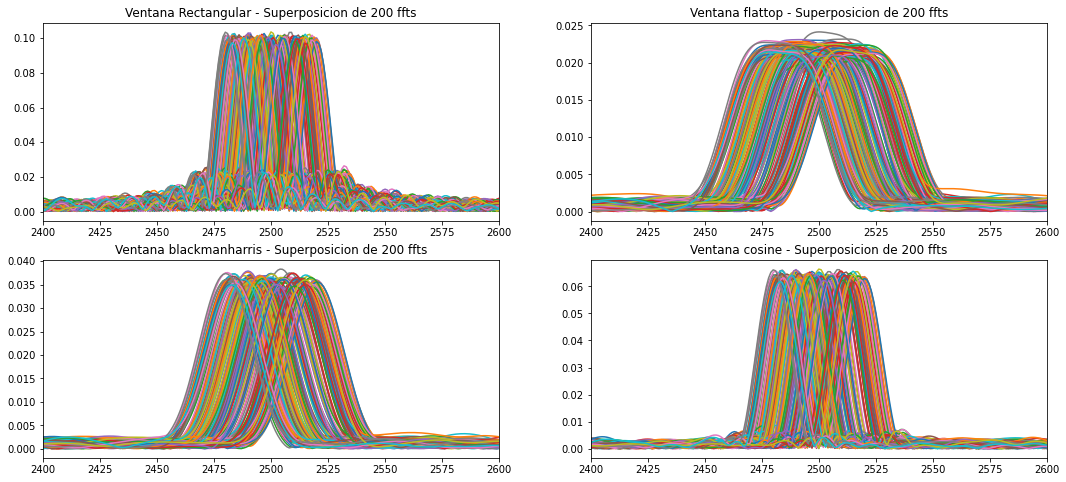

In [11]:
estimaciones_amp = np.zeros((len(arr_W), cant_realizaciones)) # Matriz de 4 filas 200 columnas
estimaciones_freq = np.zeros((len(arr_W), cant_realizaciones))

arr_ffts = np.zeros((len(arr_W), cant_realizaciones, N), dtype=complex)
for j in range(len(arr_W)):
    for i in range(cant_realizaciones):
        x_selec = x_3dB[i]  # señal i de doscientas
        w_selec = arr_W[j]  # Ventana 0 de cuatro, la rectangular (rectangular, flattop, blackmanharris, cosine)
        amplitud, frecuencia, fft_x = estimar_amp_frec(x_selec, w_selec)

        estimaciones_amp[j][i] = amplitud / N
        estimaciones_freq[j][i] = frecuencia
        arr_ffts[j,i, :] = fft_x / N
        
plt.figure(figsize=(18, 8))
for j in range(len(arr_W)):
    plt.subplot(2,2,j+1)
    plt.title(f"Ventana {arr_titulos_W[j]} - Superposicion de {cant_realizaciones} ffts")
    for i in np.arange(cant_realizaciones):
        plt.plot(np.real(arr_ffts[j][i]))
    plt.xlim(2400,2600)    
plt.show()

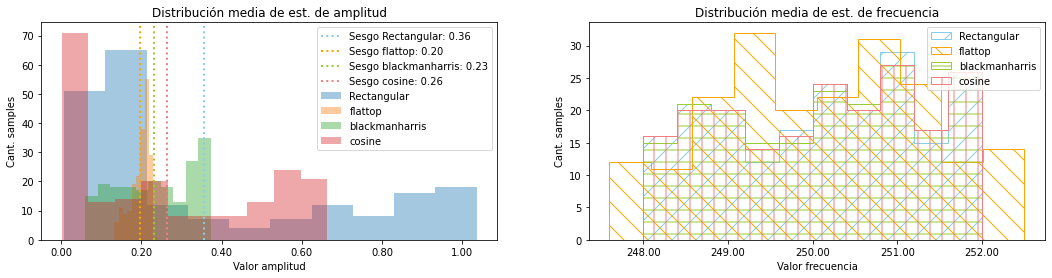

,Ventana,Sesgo,Varianza
0,Rectangular,0.035633,0.001084
1,flattop,0.019556,0.000005
2,blackmanharris,0.023236,0.000087
3,cosine,0.026439,0.000519


,Ventana,Sesgo,Varianza
0,Rectangular,0.000078,132.168775
1,flattop,0.000101,156.064975
2,blackmanharris,0.000082,132.337600
3,cosine,0.000081,132.723900


In [12]:
arr_colores = ['skyblue', 'orange', 'yellowgreen', 'lightcoral']
arr_hatch = ['/', '\\', '-', '|']
arr_amp = []; arr_var_amp = []
arr_frec = []; arr_var_frec = []
plt.figure(figsize=(18, 4))
for i in range(4):
    # Sesgo y varianza de amplitud
    mu_amp = np.mean(estimaciones_amp[i])
    sesgo_amp = mu_amp - (a0 / N)
    varianza_amp = np.mean((estimaciones_amp[i] - mu_amp)**2)
    arr_amp.append(sesgo_amp); arr_var_amp.append(varianza_amp) # Guardo valores

    # Sesgo y varianza de frecuencia
    mu_freq = np.mean(estimaciones_freq[i])
    sesgo_freq = (mu_freq/N) - (omega0/(2*np.pi))
    varianza_freq = np.mean((estimaciones_freq[i] - mu_freq)**2)
    arr_frec.append(sesgo_freq); arr_var_frec.append(varianza_freq) # Guardo valores
 
    plt.subplot(1,2,1)
    plt.hist(estimaciones_amp[i], 10, alpha=0.4, label=f"{arr_titulos_W[i]}"); plt.title("Distribución media de est. de amplitud"); plt.xlabel("Valor amplitud"); plt.ylabel("Cant. samples")
    plt.axvline(sesgo_amp, color=arr_colores[i], linestyle=':', linewidth=2, label=f'Sesgo {arr_titulos_W[i]}: {sesgo_amp*10:.2f}')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f'{val*10:.2f}'))
    plt.legend()
    plt.subplot(1,2,2)
    plt.hist(estimaciones_freq[i], 10, histtype='stepfilled', hatch=arr_hatch[i], edgecolor=arr_colores[i], facecolor='none', label=f"{arr_titulos_W[i]}")
    plt.title("Distribución media de est. de frecuencia"); plt.xlabel("Valor frecuencia"); plt.ylabel("Cant. samples")
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f'{val/10:.2f}'))
    #plt.axvline(sesgo_freq, linestyle='--', linewidth=2, label=f'Sesgo {arr_titulos_W[i]}: {sesgo_freq:.2f}')
    plt.legend()
plt.show()

df_amp = pd.DataFrame({
    'Ventana': arr_titulos_W,
    'Sesgo': arr_amp,
    'Varianza': arr_var_amp,
})
df_amp = df_amp.style.set_caption("Estimación de Amplitud")
df_amp

df_frec = pd.DataFrame({
    'Ventana': arr_titulos_W,
    'Sesgo': arr_frec,
    'Varianza': arr_var_frec
})
df_frec = df_frec.style.set_caption("Estimación de Frecuencia")
df_frec

display(df_amp)
display(df_frec)

## Análisis de resultados

## Bonus
- 💎 Analice el efecto del zero-padding para el estimador Ω^1 ✅ __Hecho__
 
- 🤯 Proponga estimadores alternativos para frecuencia y amplitud de la senoidal y repita el experimento. __Pendiente__

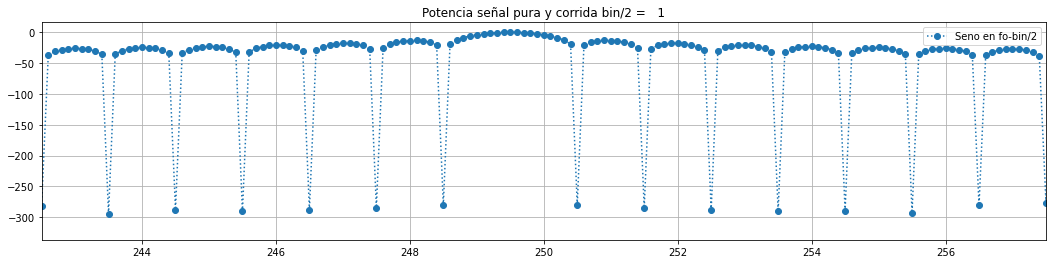

In [13]:
fs = 1000       # Frecuencia de muestreo [Hz]
N = fs          # cantidad de muestras
fo = fs/4       # [Hz]

Vmax = np.sqrt(2) #[Volts]
df = fs/N # resolución espectral

bin = fs/N

tt = np.arange(N) / fs
s_puro = Vmax * np.sin(tt*2*np.pi*fo)
s_var = Vmax * np.sin(tt*2*np.pi*(fo-(bin/2)))
sen_arr = 0
for i in range(20):
    sen_arr += Vmax * np.sin(tt*2*np.pi*(fo-(i*bin/2)))

s_var = np.concatenate((np.zeros(N*9), s_var))
ff = np.arange(0,fs,df/10) # 10 porque aumente por 10 el N
#ff = np.arange(0,fs,df)
fft_s = fft(s_puro) / N
fft_svar = fft(s_var) / N
fft_arr = fft(sen_arr) / N

plt.figure(figsize=(18, 4))
#plt.plot(ff, 20*np.log10(np.abs(fft_s)*np.sqrt(2)), ':x', label='Seno en fo',)
plt.plot(ff, 20*np.log10(np.abs(fft_svar)*np.sqrt(2)), ':o', label='Seno en fo-bin/2')
#plt.plot(ff, 20*np.log10(np.abs(fft_arr)*np.sqrt(2)), label='Sen arr')
plt.legend(); plt.xlim(fo*0.97,fo*1.03);plt.grid();plt.title("Potencia señal pura y corrida bin/2 = {:3.0f}".format(bin))
plt.show()